# Principal Component Analysis of Pokemon Data
This is a quick look at the Pokemon data, but instead at the variables themselves, we perform a PCA to get a reduced number of variables and examine the results. 

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
%matplotlib inline

In [3]:
df = pd.read_csv('Pokemon.csv')

columns = df.columns.tolist()
columns[0] = 'id'
df.columns = columns
cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
df.head()

,id,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [5]:
scaler = StandardScaler().fit(df[cols])
df_scaled = scaler.transform(df[cols])

print(df_scaled[:,0].mean())  # zero (or very close)
print(df_scaled[:,0].std())  # 1 (or very close)

-2.486899575160351e-16
1.0


I opt to use as many principal components as necessary to explain 80% of the variance in the original dataset.

In [8]:
pca = PCA(n_components=0.8)  # consider enough components to explain 80% of the variance
pca.fit(df_scaled)
pcscores = pd.DataFrame(pca.transform(df_scaled))
pcscores.columns = ['PC'+str(i+1) for i in range(len(pcscores.columns))]
loadings = pd.DataFrame(pca.components_, columns=cols)
loadings.index = ['PC'+str(i+1) for i in range(len(pcscores.columns))]

[Text(0, 0.5, 'HP'),
 Text(0, 1.5, 'Attack'),
 Text(0, 2.5, 'Defense'),
 Text(0, 3.5, 'Sp. Atk'),
 Text(0, 4.5, 'Sp. Def'),
 Text(0, 5.5, 'Speed')]

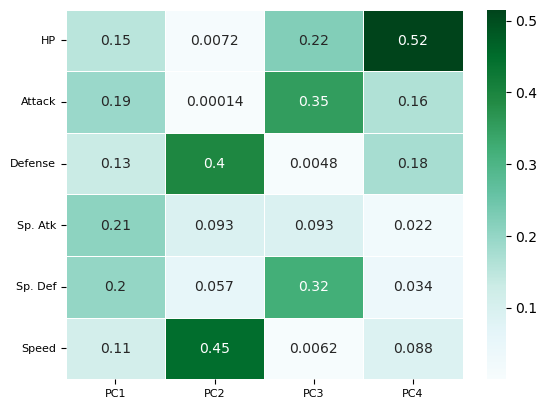

In [10]:
load_sqr = loadings**2
ax = sns.heatmap(load_sqr.transpose(), linewidths=0.5, cmap="BuGn", annot=True)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0, fontsize=8)
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=8)

The darkest shades in the plot above indicate which parameters are the most important. For example, the loading factors for PC4 show that HP is the most dominant parameter. That is, Pokemon with high HP will have high absolute values of PC4.

Let's look at the actual values of the loading factors now:

[Text(0, 0.5, 'HP'),
 Text(0, 1.5, 'Attack'),
 Text(0, 2.5, 'Defense'),
 Text(0, 3.5, 'Sp. Atk'),
 Text(0, 4.5, 'Sp. Def'),
 Text(0, 5.5, 'Speed')]

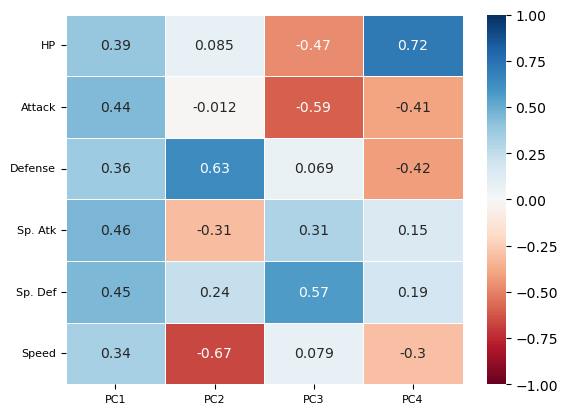

In [12]:
ax = sns.heatmap(loadings.transpose(), center=0, linewidths=0.5, 
                 cmap="RdBu", vmin=-1, vmax=1, annot=True)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0, fontsize=8)
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=8)

Here you can see some more trends. For example, a Pokemon with high Defense or low Speed will have a positive value of PC2. On the other hand, things like Attack or Sp. Defense will control what value a Pokemon will have for PC3.

Yet another way to look at this is to examine the data with a biplot, which is a scatter plot with vectors indicating what direction a datapoint will take in the PCA given its underlying parameters. For fun, I will color-code the Pokemon by Type to see if there is any obvious trends.

In [39]:
# Create labels based on Type 1
labels = set(df['Type 1'])
df['type'] = df['Type 1']
lab_dict = dict()
for i, elem in enumerate(labels):
    lab_dict[elem] = i
df = df.replace({'type' : lab_dict})

pc_types = pcscores.copy()
pc_types['Type'] = df['Type 1']

# Biplots
def make_plot(pcscores, loadings, xval=0, yval=1, max_arrow=0.2, alpha=0.4):
    n = loadings.shape[1]
    scalex = 1.0 / (pcscores.iloc[:, xval].max() - pcscores.iloc[:, xval].min())  # Rescaling to be from -1 to +1
    scaley = 1.0 / (pcscores.iloc[:, yval].max() - pcscores.iloc[:, yval].min())

    pcscores.iloc[:, xval] = pcscores.iloc[:, xval] * scalex
    pcscores.iloc[:, yval] = pcscores.iloc[:, yval] * scaley

    g = sns.lmplot(x='PC{}'.format(xval + 1), y='PC{}'.format(yval + 1), hue='Type', data=pcscores,fit_reg=False,  palette='muted')

    for i in range(n):
        # Only plot the longer ones
        length = sqrt(loadings.iloc[xval, i] ** 2 + loadings.iloc[yval, i] ** 2)
        if length < max_arrow:
            continue

        plt.arrow(0, 0, loadings.iloc[xval, i], loadings.iloc[yval, i], color='k', alpha=0.9)
        plt.text(loadings.iloc[xval, i] * 1.15, loadings.iloc[yval, i] * 1.15,
                 loadings.columns.tolist()[i], color='k', ha='center', va='center')

    g.set(ylim=(-1, 1))
    g.set(xlim=(-1, 1))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6740\2026311590.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'type' : lab_dict})


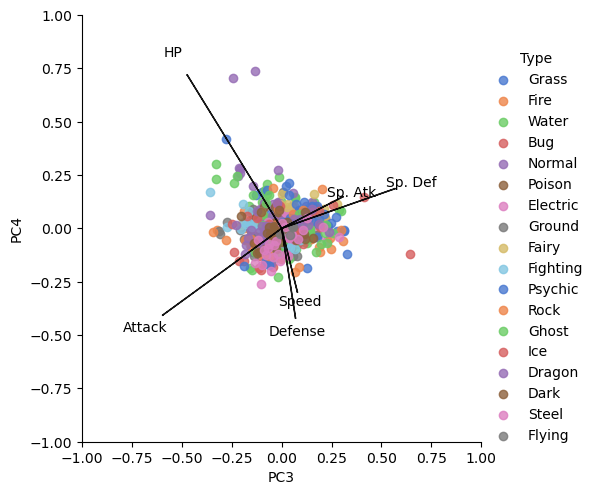

In [41]:

make_plot(pc_types, loadings, 2, 3, max_arrow=0.3)

Above, you can see that Pokemon are primarily centrally distributed; that is, their stats are fairly balanced. There don't appear to be any obvious trends with type. There are some outliers, for example, 2 normal type Pokemon with high values of PC4. If you recall, PC4's loading factors indicated that HP was the dominant parameter. 

In [44]:
best = pc_types.sort_values(by='PC4', ascending=False)[:2]
df.loc[best.index]

,id,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,type
261,242,Blissey,Normal,NaN,540,255,10,10,75,135,55,2,False,4
121,113,Chansey,Normal,NaN,450,250,5,5,35,105,50,1,False,4


In [46]:
# Top HP Pokemon:
df.sort_values(by='HP', ascending=False)[:2]

,id,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,type
261,242,Blissey,Normal,NaN,540,255,10,10,75,135,55,2,False,4
121,113,Chansey,Normal,NaN,450,250,5,5,35,105,50,1,False,4


Indeed, the Pokemons with the highest HP also have the highest PC4, as expected.

Let's have a look at all the PC combinations with a Seaborn pairplot:

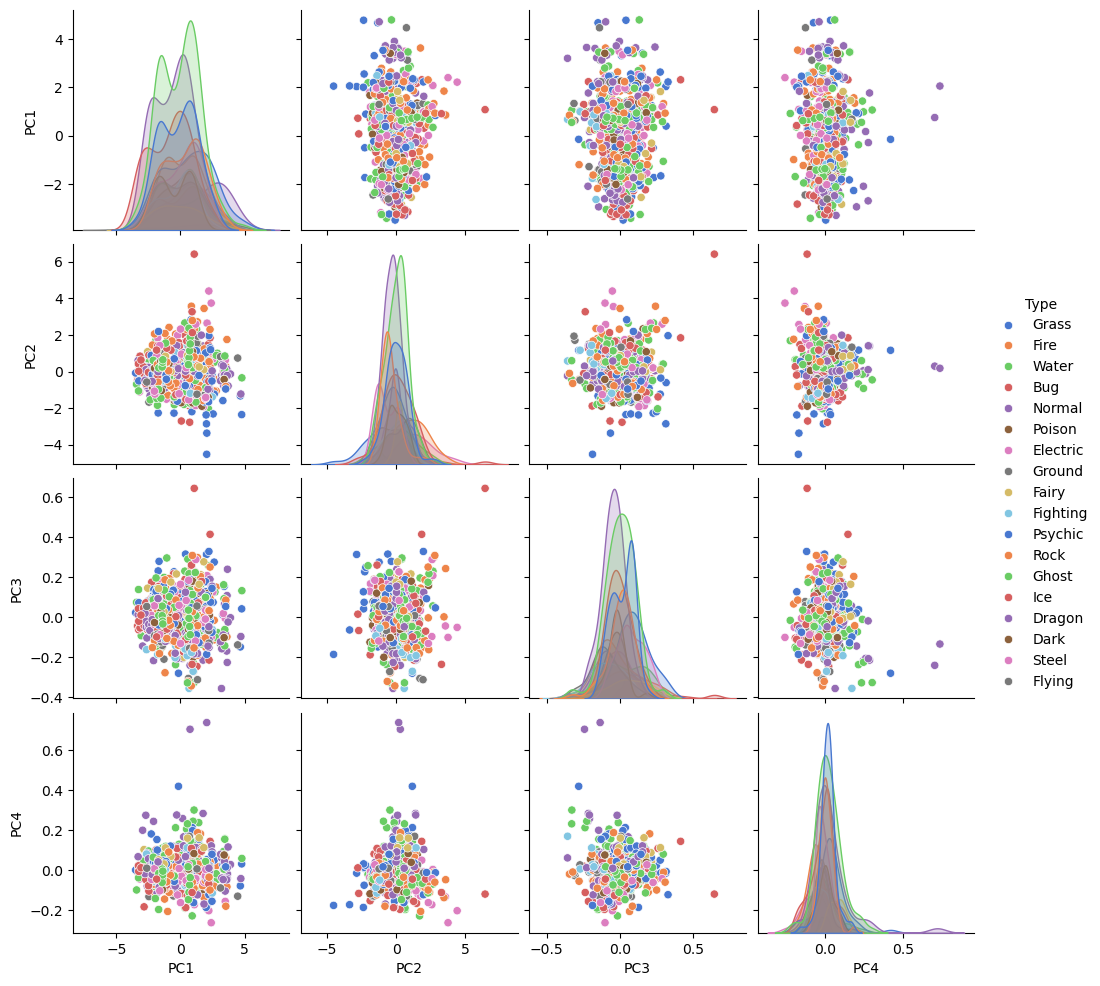

In [50]:
g = sns.pairplot(pc_types, hue='Type', palette='muted')

Again, we can't see a strong trend with Pokemon type. Out of curiosity, what's the Bug-type pokemon with high PC2 and PC3 values?

In [52]:
print(pc_types.sort_values(by='PC2', ascending=False)[:1])
print(pc_types.sort_values(by='PC3', ascending=False)[:1])

          PC1      PC2       PC3       PC4 Type
230  1.076565  6.41447  0.642885 -0.118412  Bug
          PC1      PC2       PC3       PC4 Type
230  1.076565  6.41447  0.642885 -0.118412  Bug


In [53]:
df.loc[230]

id                213
Name          Shuckle
Type 1            Bug
Type 2           Rock
Total             505
HP                 20
Attack             10
Defense           230
Sp. Atk            10
Sp. Def           230
Speed               5
Generation          2
Legendary       False
type                7
Name: 230, dtype: object

This is Shuckle, a bug-type Pokemon with very high Defense and Sp. Def at the cost of Attack attributes. Indeed, the PC2-PC3 biplot reveals how it can be used to select high-defense Pokemon. These will be located towards the top right (high PC2 and PC3 values).

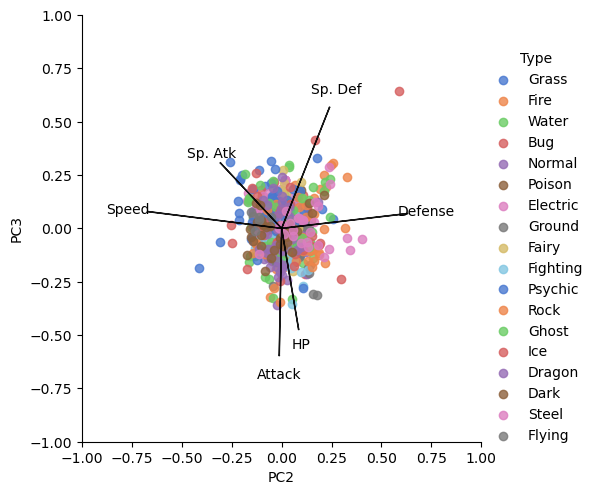

In [55]:
make_plot(pc_types, loadings, 1, 2, max_arrow=0.3)